## Documentation 
* Référence pour les coordonnées LV95 <-> WGS, voir https://www.swisstopo.admin.ch/dam/en/sd-web/KLRCX9XIdXDu/ch1903wgs84-EN.pdf. 
Selon la formule SwissTopo, la précision est e l'ordre de 1 mètre. 
La fonction est bien plus rapide que les outils de conversion classiques.

* voir aussi https://github.com/ValentinMinder/Swisstopo-WGS84-LV03/blob/master/README.md

* pour les données Météo-Suisse : voir https://www.meteoswiss.admin.ch/services-and-publications/service/open-data.html

* pour la signification des abréviations employées par Météo-Suisse : voir https://data.geo.admin.ch/ch.meteoschweiz.ogd-smn/ogd-smn_meta_parameters.csv

* pour les méta-données sur les postes manuels : https://opendatadocs.meteoswiss.ch/a-data-groundbased/a5-manual-precipitation-stations

* pour les méta-données sur les postes automatiques : https://opendatadocs.meteoswiss.ch/a-data-groundbased/a1-automatic-weather-stations

Pour les données topographiques, des téléchargements externes peuvent être nécessaires (voir la doc au niveau des exemples). Mais on peut faire sans cela en se servant de plotly.


## Mode d'emploi 
1. initialiser les fonctions spatiales et météo
2. tracer la carte des stations
3. localiser la station d'intérêt et son nom
4. il est toujours possible de filtrer. Par exemple, pour avoir toutes les stations météo du valais, il suffit de taper
  liste_propriétés_stations[liste_propriétés_stations['canton']=='VS']
5. télécharger les données souhaitées. Différentes fonctions sont proposées :
    * télécharger_variable_station : télécharge la série temporelle correspondante à une variable (parmi huit possibles : température, précipitations, etc) pour une station
    * télécharger_toutes_données_station : télécharge la série temporelle correspondante à chaque variable disponible pour une station, Voir la liste des abréviations
      employées par Météo-Suisse pour l'interprétation
    * télécharger_précipitations :  télécharge la série temporelle des précipitations journalières pour une station
    * synthétiser_information_pluviométrique : synthétise l'information pluviométrique pour un ensemble ou la totalité des stations
6. des exemples de figure sont donnés

En principe il est possible de travailler à différentes granularités (selon le pas de temps de la station de mesure), mais tout n'a pas été testé pour l'heure. Et attention au volume de données !

Dernière mise à jour : mardi 9 septembre 2025


# Initialisation

In [ ]:
%matplotlib inline
# kernel : my_python_user
import pandas as pd
# pd.set_option('display.max_rows', None)        # à décommenter si on veut afficher tout le dataframe
import numpy as np
import zipfile
import io
import os
import sys
import datetime
import json
import requests
from pathlib import Path
import matplotlib.pyplot as plt
 
import plotly.graph_objects as go
import logging                                 # désactivation des messages de kaleido
# Désactiver les logs de Kaleido
logging.getLogger('kaleido').setLevel(logging.WARNING)
logging.getLogger('choreographer').setLevel(logging.WARNING)

from matplotlib import colors as mcolors
colors = mcolors._colors_full_map
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import PowerNorm
from matplotlib.colors import LightSource

import geopandas as gpd
from scipy.interpolate import RegularGridInterpolator
import xarray as xr                               # gestion des xarray
import cartopy.crs as ccrs                        # cartographie
import cartopy.feature as cfeature

from tabulate import tabulate                     # impression du texte dans un format tabulé
import yaml
import plotly.express as px
from scipy import stats                           # calage d'une tendance linéaire pour les températures
from shapely.vectorized import contains
from scipy.ndimage import zoom
from scipy.ndimage import gaussian_filter
import rioxarray
from rasterio.enums import Resampling
from adjustText import adjust_text
from geopy.distance import geodesic
plt.rcParams['text.usetex'] = True                # paramètres latex
plt.rcParams['text.latex.preamble'] = '\\usepackage{libertine}'
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
plt.style.use('default')
date_calcul        = datetime.date.today()
année_en_cours     = date_calcul.year 

import geopandas as gpd
import sys
from pathlib import Path
import requests
from shapely.geometry import Point, shape
from tqdm import tqdm

print("GeoPandas version:", gpd.__version__)
print("Python version:", sys.version)


#################################
## Auteur : Christophe Ancey   ##
## Date : Mai 2024             ##
## Mise à jour : 9 sep. 2025   ##
#################################

GeoPandas version: 1.1.1
Python version: 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:20:11) [MSC v.1938 64 bit (AMD64)]


## Conversion coordonnées

In [18]:
def convertir_LV05_vers_WGS84(x, y):
    """ 
    Convertir des coordonnées du système LV95 en coordonnées géographiques (lon, lat)
    Entrée : 
        * x, y : coordonnées LV 95
    Sortie :
        * longitude, latitude
    """
    # Coordonnées auxiliaires
    x_aux = (x - 2600000) / 1000000
    y_aux = (y - 1200000) / 1000000
    
    # Formules officielles SwissTopo
    lon = 2.6779094 + 4.728982 * x_aux + 0.791484 * x_aux * y_aux + 0.1306 * x_aux * y_aux**2 - 0.0436 * x_aux**3
    lat = 16.9023892 + 3.238272 * y_aux - 0.270978 * x_aux**2 - 0.002528 * y_aux**2 - 0.0447 * x_aux**2 * y_aux - 0.0140 * y_aux**3
    
    # Conversion finale
    return lon * 100 / 36, lat * 100 / 36

def convertir_WGS84_vers_LV95(longitude, latitude):
    """
    Convertir des coordonnées géographiques WGS84 en coordonnées du système LV95
    Entrée :
        * longitude : longitude en degrés décimaux
        * latitude  : latitude en degrés décimaux
    Sortie :
        * x, y      : coordonnées LV95  
    """
    
    # 1. Convertir les coordonnées géographiques en secondes d'arc
    phi_seconds    = latitude  * 3600  # latitude en secondes d'arc
    lambda_seconds = longitude * 3600  # longitude en secondes d'arc
    
    # 2. Calculer les valeurs auxiliaires (différences par rapport à Bern en unité [10000"])
    phi_prime    = (phi_seconds - 169028.66) / 10000
    lambda_prime = (lambda_seconds - 26782.5) / 10000
    
    # 3. Calculer les coordonnées de projection LV95 (E, N)
    E = (2600072.37 
         + 211455.93 * lambda_prime 
         - 10938.51 * lambda_prime * phi_prime 
         - 0.36 * lambda_prime * phi_prime**2 
         - 44.54 * lambda_prime**3)
    
    N = (1200147.07 
         + 308807.95 * phi_prime 
         + 3745.25 * lambda_prime**2 
         + 76.63 * phi_prime**2 
         - 194.56 * lambda_prime**2 * phi_prime 
         + 119.79 * phi_prime**3)
    
    return E, N

def convertir_WGS84_vers_LV03(longitude, latitude):
    """
    Convertir des coordonnées géographiques WGS84 en coordonnées du système LV03
    Entrée :
        * longitude : longitude en degrés décimaux
        * latitude : latitude en degrés décimaux
    Sortie :
        * x, y : coordonnées LV03
    """
    # Obtenir d'abord les coordonnées LV95
    E, N = convertir_WGS84_vers_LV95(longitude, latitude)
    
    # Convertir LV95 vers LV03
    y = E - 2000000.00
    x = N - 1000000.00
    
    return x, y

## Fonctions spatiales : villes

In [19]:
def lister_villes_suisses(verbosité  = False, pandas_format = True):
    """
    Retourne directement les données des principales villes suisses
    avec population, canton et coordonnées (WGS84).
    
    options :
        * verbosité : afficher les messages
        * pandas_true : sortie sous forme de DataFrame ou sinon de dictionnaire

    Sortie :
        si pandas_format : objet de type pandas.DataFrame: DataFrame avec colonnes 'nom_ville', 'canton', 'population', 'latitude', 'longitude'
        sinon : dictionnaire
    """

    # Données officielles des principales villes suisses (2023) sous forme de dictionnaire
    données = [
        {"nom": "Zurich", "canton": "ZH", "population": 434008, "latitude": 47.3769, "longitude": 8.5417},
        {"nom": "Genève", "canton": "GE", "population": 203856, "latitude": 46.2044, "longitude": 6.1432},
        {"nom": "Bâle", "canton": "BS", "population": 177595, "latitude": 47.5596, "longitude": 7.5886},
        {"nom": "Lausanne", "canton": "VD", "population": 140202, "latitude": 46.5197, "longitude": 6.6323},
        {"nom": "Berne", "canton": "BE", "population": 134794, "latitude": 46.9481, "longitude": 7.4474},
        {"nom": "Winterthour", "canton": "ZH", "population": 114220, "latitude": 47.4979, "longitude": 8.7240},
        {"nom": "Lucerne", "canton": "LU", "population": 82257, "latitude": 47.0502, "longitude": 8.3093},
        {"nom": "Saint-Gall", "canton": "SG", "population": 76213, "latitude": 47.4245, "longitude": 9.3767},
        {"nom": "Lugano", "canton": "TI", "population": 62315, "latitude": 46.0037, "longitude": 8.9511},
        {"nom": "Bienne", "canton": "BE", "population": 55206, "latitude": 47.1427, "longitude": 7.2466},
        {"nom": "Thoune", "canton": "BE", "population": 43476, "latitude": 46.7578, "longitude": 7.6283},
        {"nom": "Köniz", "canton": "BE", "population": 42909, "latitude": 46.9244, "longitude": 7.4156},
        {"nom": "La Chaux-de-Fonds", "canton": "NE", "population": 36915, "latitude": 47.1057, "longitude": 6.8262},
        {"nom": "Fribourg", "canton": "FR", "population": 38039, "latitude": 46.8058, "longitude": 7.1608},
        {"nom": "Schaffhouse", "canton": "SH", "population": 36952, "latitude": 47.6972, "longitude": 8.6303},
        {"nom": "Coire", "canton": "GR", "population": 36453, "latitude": 46.8529, "longitude": 9.5307},
        {"nom": "Uster", "canton": "ZH", "population": 35337, "latitude": 47.3463, "longitude": 8.7208},
        {"nom": "Sion", "canton": "VS", "population": 34978, "latitude": 46.2337, "longitude": 7.3596},
        {"nom": "Neuchâtel", "canton": "NE", "population": 33712, "latitude": 46.9930, "longitude": 6.9293},
        {"nom": "Vernier", "canton": "GE", "population": 35040, "latitude": 46.2167, "longitude": 6.0833},
        {"nom": "Lancy", "canton": "GE", "population": 32568, "latitude": 46.1889, "longitude": 6.1178},
        {"nom": "Kriens", "canton": "LU", "population": 27995, "latitude": 47.0357, "longitude": 8.2784},
        {"nom": "Yverdon-les-Bains", "canton": "VD", "population": 31451, "latitude": 46.7785, "longitude": 6.6413},
        {"nom": "Montreux", "canton": "VD", "population": 26574, "latitude": 46.4312, "longitude": 6.9123},
        {"nom": "Dübendorf", "canton": "ZH", "population": 30765, "latitude": 47.3975, "longitude": 8.6186},
        {"nom": "Dietikon", "canton": "ZH", "population": 28141, "latitude": 47.4014, "longitude": 8.4008},
        {"nom": "Zug", "canton": "ZG", "population": 30934, "latitude": 47.1663, "longitude": 8.5152},
        {"nom": "Carouge", "canton": "GE", "population": 22709, "latitude": 46.1833, "longitude": 6.1389},
        {"nom": "Wädenswil", "canton": "ZH", "population": 23147, "latitude": 47.2287, "longitude": 8.6689},
        {"nom": "Aarau", "canton": "AG", "population": 21726, "latitude": 47.3911, "longitude": 8.0456},
        {"nom": "Olten", "canton": "SO", "population": 18827, "latitude": 47.3497, "longitude": 7.9058},
        {"nom": "Nyon", "canton": "VD", "population": 22286, "latitude": 46.3833, "longitude": 6.2389},
        {"nom": "Renens", "canton": "VD", "population": 21936, "latitude": 46.5364, "longitude": 6.5889},
        {"nom": "Emmen", "canton": "LU", "population": 30806, "latitude": 47.0814, "longitude": 8.3006},
        {"nom": "Rapperswil-Jona", "canton": "SG", "population": 27547, "latitude": 47.2269, "longitude": 8.8178},
        {"nom": "Horgen", "canton": "ZH", "population": 22693, "latitude": 47.2597, "longitude": 8.5989},
        {"nom": "Morges", "canton": "VD", "population": 16016, "latitude": 46.5111, "longitude": 6.4989},
        {"nom": "Meyrin", "canton": "GE", "population": 25101, "latitude": 46.2361, "longitude": 6.0833},
        {"nom": "Bulle", "canton": "FR", "population": 23482, "latitude": 46.6158, "longitude": 7.0564},
        {"nom": "Steffisburg", "canton": "BE", "population": 16703, "latitude": 46.7789, "longitude": 7.6333},
        {"nom": "Baden", "canton": "AG", "population": 19658, "latitude": 47.4736, "longitude": 8.3064},
        {"nom": "Frauenfeld", "canton": "TG", "population": 25447, "latitude": 47.5539, "longitude": 8.8989},
        {"nom": "Bellinzona", "canton": "TI", "population": 18196, "latitude": 46.1939, "longitude": 9.0178},
        {"nom": "Vevey", "canton": "VD", "population": 19827, "latitude": 46.4636, "longitude": 6.8428},
        {"nom": "Pully", "canton": "VD", "population": 18424, "latitude": 46.5097, "longitude": 6.6658},
        {"nom": "Soleure", "canton": "SO", "population": 16777, "latitude": 47.2081, "longitude": 7.5364},
        {"nom": "Wettingen", "canton": "AG", "population": 20686, "latitude": 47.4667, "longitude": 8.3206},
        {"nom": "Gossau", "canton": "SG", "population": 17881, "latitude": 47.4150, "longitude": 9.2531},
        {"nom": "Bülach", "canton": "ZH", "population": 21093, "latitude": 47.5206, "longitude": 8.5406},
    ]
    
    if verbosité: print(f"Chargement des données des villes suisses... Le fichier comprend {len(données)}")

    # Créer le DataFrame
    df = pd.DataFrame(données)
    
    # Renommer les colonnes pour correspondre au format demandé
    données_df = pd.DataFrame({
        'nom_ville': df['nom'],
        'canton': df['canton'], 
        'population': df['population'],
        'latitude': df['latitude'],
        'longitude': df['longitude']
    })
    
    # Trier par population décroissante
    données_df = données_df.sort_values('population', ascending=False).reset_index(drop=True)
    if pandas_format:
        return données_df 
    else:
        return données

In [36]:
def télécharger_villes_swisstopo(verbosité = True):

    """
    Télécharge les coordonnées depuis SwissTopo  
    Option :
        * verbosité pour afficher les messages d'exécution
    Sortie :
        * pandas.DataFrame: DataFrame avec commune, lieu-dit (une commune peut avoir plusieurs lieu-dits), x, y, latitude, longitude, canton, code postal
    """
    
    zip_url = "https://data.geo.admin.ch/ch.swisstopo-vd.ortschaftenverzeichnis_plz/ortschaftenverzeichnis_plz/ortschaftenverzeichnis_plz_2056.csv.zip"
    if verbosité: print(f"Téléchargement la liste des villes avec coordonnées LV95 depuis {zip_url}...")
    try:
        response = requests.get(zip_url, timeout=60)
        response.raise_for_status()
        
        if verbosité: print(f"J'ai téléchargé le fichier SwissTopo de taille ({len(response.content)} bytes)")
        
        with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
            # Prendre le premier fichier CSV
            csv_files = [f for f in zip_file.namelist() if f.endswith('.csv')]
            
            if not csv_files:
                raise Exception("Erreur : aucun CSV dans l'archive ! (Vérifier l'adresse url)")
            
            csv_file = csv_files[0]
            if verbosité: print(f"* Je lis le fichier {csv_file}")
            
            with zip_file.open(csv_file) as csv_data:
                df = pd.read_csv(csv_data, sep=';', encoding='utf-8')
                
                if verbosité: print(f"* Il y a {len(df)} lignes et {len(list(df.columns))} colonnes.  ")

                # Créer le DataFrame 
                coords_df = pd.DataFrame({
                    'commune': df['Gemeindename'],
                    'lieu-dit': df['Ortschaftsname'],
                    'x': pd.to_numeric(df['E'], errors='coerce'),
                    'y': pd.to_numeric(df['N'], errors='coerce'),
                    'canton': df['Kantonskürzel'],
                    'code_postal': pd.to_numeric(df['PLZ'], errors='coerce')
                })
                
                # Supprimer les lignes invalides
                coords_df = coords_df.dropna()
                
                # Convertir LV95 vers WGS84 (formules SwissTopo)
                if verbosité: print("* Je convertis les coordonnées LV95 en WGS84...")
                coords_list = coords_df.apply(lambda row: convertir_LV05_vers_WGS84(row['x'], row['y']), axis=1)
                
                coords_df['longitude'] = [c[0] for c in coords_list]
                coords_df['latitude']  = [c[1] for c in coords_list]
                
                # Résultat final
                résultat = coords_df[['commune','lieu-dit', 'latitude', 'longitude','x','y','code_postal']].copy()
                
                print(f"En tout j'ai trouvé {len(résultat)} localités avec leurs coordonnées.")
                return résultat
                
    except Exception as e:
        print(f"Erreur :  {e} !")
        return None

liste_villes = lister_villes_suisses()
print(f"J'ai défini une liste de {len(liste_villes)} villes avec les données de population.")
villes  = télécharger_villes_swisstopo(verbosité = False)
lat_min = villes['latitude'].min()-.02
lat_max = villes['latitude'].max()+.02
lon_min = villes['longitude'].min()-.02
lon_max = villes['longitude'].max()+.02
central_latitude = (lat_min + lat_max)/2
central_longitude = (lon_min + lon_max)/2

J'ai défini une liste de 49 villes avec les données de population.
En tout j'ai trouvé 5737 localités avec leurs coordonnées.


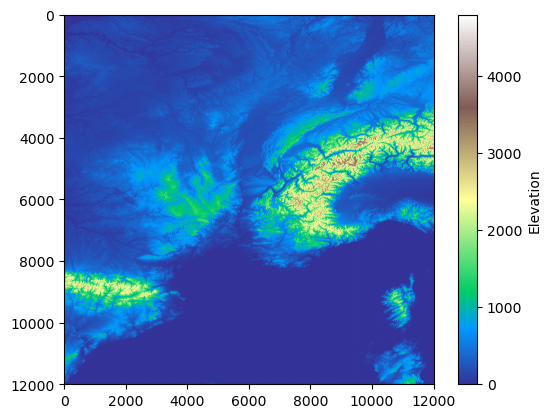

In [37]:
# données MNT Alpes tiré de https://ec.europa.eu/eurostat/web/gisco/geodata/digital-elevation-model/copernicus#Elevation

mnt_adresse = "/Data/Cartographie/DEM/10_DEM_y40x0.tif"
elevation_da = rioxarray.open_rasterio(mnt_adresse, masked=True)
elevation_2d = elevation_da.squeeze()

# Now plot
plt.imshow(elevation_2d, cmap='terrain', origin='upper')
plt.colorbar(label='Elevation')
plt.show()

In [38]:
# Découpage pour les besoins
 
cadre_limite      = (lon_min, lat_min, lon_max, lat_max)
carte_extension   = [lon_min, lon_max, lat_max, lat_min]  
elevation_clipped = elevation_da.rio.clip_box(*cadre_limite).squeeze()
 

# Extraction des données
elevation = elevation_clipped.values
lon = elevation_clipped['x'].values
lat = elevation_clipped['y'].values
# Vérification
if lat[0] < lat[-1]:
    lat = lat[::-1]
    elevation = elevation[::-1, :]

# création d'un relief par ombrage
ls        = LightSource(azdeg=315, altdeg=45)
hillshade = ls.shade(elevation, cmap=plt.cm.Greys, blend_mode='overlay')


In [39]:
# https://www.hydrosheds.org/
# créer les fichiers avec hydroshed_geonames.ipynb
fichier_rivière = '/Data/Cartographie/hydrosheds/rivières_alpes.gpkg'
fichier_lac     = '/Data/Cartographie/hydrosheds/lacs_alpes.gpkg'
lacs            = gpd.read_file(fichier_lac)
rivières        = gpd.read_file(fichier_rivière)
 
def fond_topographique(longitude_poste, latitude_poste, nom_poste:str, seuil_pop = 5e4,
                       taille = (18,15),projection='normal'):
    """ 
    fournit le fond topographique
    données :
    * longitude_poste, 
    * latitude_poste, 
    * nom_poste: string
    * seuil_pop : par défaut 50 000 habitants. Seuil à partir duquel on trace les villes
    * taille : fournit la taille de l'image par rapport aux coordonnées du poste
    * taille: par défaut (18,15)
    * projection='normal' si on choisit "lambert", la carte aura une projection de type
      Lambert conforme (le temps de traçage est deux fois plus grand)
    """


    fig = plt.figure(figsize=taille, facecolor = 'w')
    if projection == 'lambert':
        ax = plt.axes(projection = ccrs.LambertConformal(central_longitude = central_longitude,
                                                    central_latitude = central_latitude))
    else:
        ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([lon_min, lon_max, lat_min, lat_max])
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.75, linestyle='-')
    gl.xlabel_style = {'size': 12, 'color': 'gray','rotation':0}
    gl.ylabel_style = {'size': 12, 'color': 'gray','rotation': 90}
    gl.top_labels = False
    gl.right_labels = False

    # villes
    plt.scatter( x= longitude_poste, y = latitude_poste, color = 'black', transform=ccrs.PlateCarree(), zorder = 200)
    plt.text( longitude_poste,latitude_poste+0.01, nom_poste, horizontalalignment='center',
            fontsize = 14, weight = 'bold', transform=ccrs.PlateCarree(), zorder = 200)
    # for villes in choix_villes: 
    #         plt.scatter(x = villes[3], y= villes[2], marker = '+', color = 'black',transform=ccrs.PlateCarree(), zorder = 200)
    #         plt.text(villes[3], villes[2]+.02, villes[0],fontsize = 12, horizontalalignment='center' , transform=ccrs.PlateCarree(), zorder = 200)
 

    # On stocke les objets texte dans une liste
    textes = []
    villes_suisses = lister_villes_suisses( )
    choix_villes = villes_suisses[ villes_suisses['population']>seuil_pop ]
     
    
    for _, ville in choix_villes.iterrows():
        lon = ville['longitude']
        lat = ville['latitude']
        nom = ville['nom_ville']

        # Le point (facultatif si déjà dessiné ailleurs)
        plt.scatter(lon, lat, marker='+', color='black', transform=ccrs.PlateCarree(), zorder=200)
        fontsize = 10 + 5 * (ville['population'] / choix_villes['population'].max())
        # Création du texte, légèrement décalé au départ
        text = plt.text(lon, lat + 0.02, nom, fontsize=fontsize, ha='center',
                        transform=ccrs.PlateCarree(), zorder=200)
        textes.append(text)
    
    # Ajustement automatique des textes pour éviter les collisions
    adjust_text(textes, 
                expand_text=(1.1, 1.5),  # expansion de l’espace autour du texte
                arrowprops=dict(arrowstyle='-', color='gray') )  # flèches vers les points

    
    #relief
    ax.imshow(
        hillshade[::-1],
        extent=carte_extension,
        transform=ccrs.PlateCarree(),
        origin='upper',
        zorder=0,
        alpha=0.9
    )
    # hydrologie
    rivières.plot(
        ax=ax,  # Plot on the same axis
        color=mcolors.CSS4_COLORS['powderblue'],
        linewidth=1,
        alpha=0.7,
        zorder=50,   
        transform=ccrs.PlateCarree()   
    )
    lacs.plot(
        ax=ax,  # Plot on the same axis
        color=mcolors.CSS4_COLORS['powderblue'] ,
        linewidth=0.8,
        alpha=0.9,
        zorder=50,   
        transform=ccrs.PlateCarree()   
    )
        #Affichage des côtes, frontières et océans
    ax.coastlines(zorder = 101)
    ax.add_feature(cfeature.BORDERS, zorder = 101, edgecolor = 'orange', ls = '--',linewidth=3)
    #ax.add_feature(cfeature.OCEAN, zorder = 99, edgecolor = 'lightgray')
    ax.add_feature(cfeature.STATES,linewidth=0.5 , edgecolor = 'orange' )
    return fig, ax
    

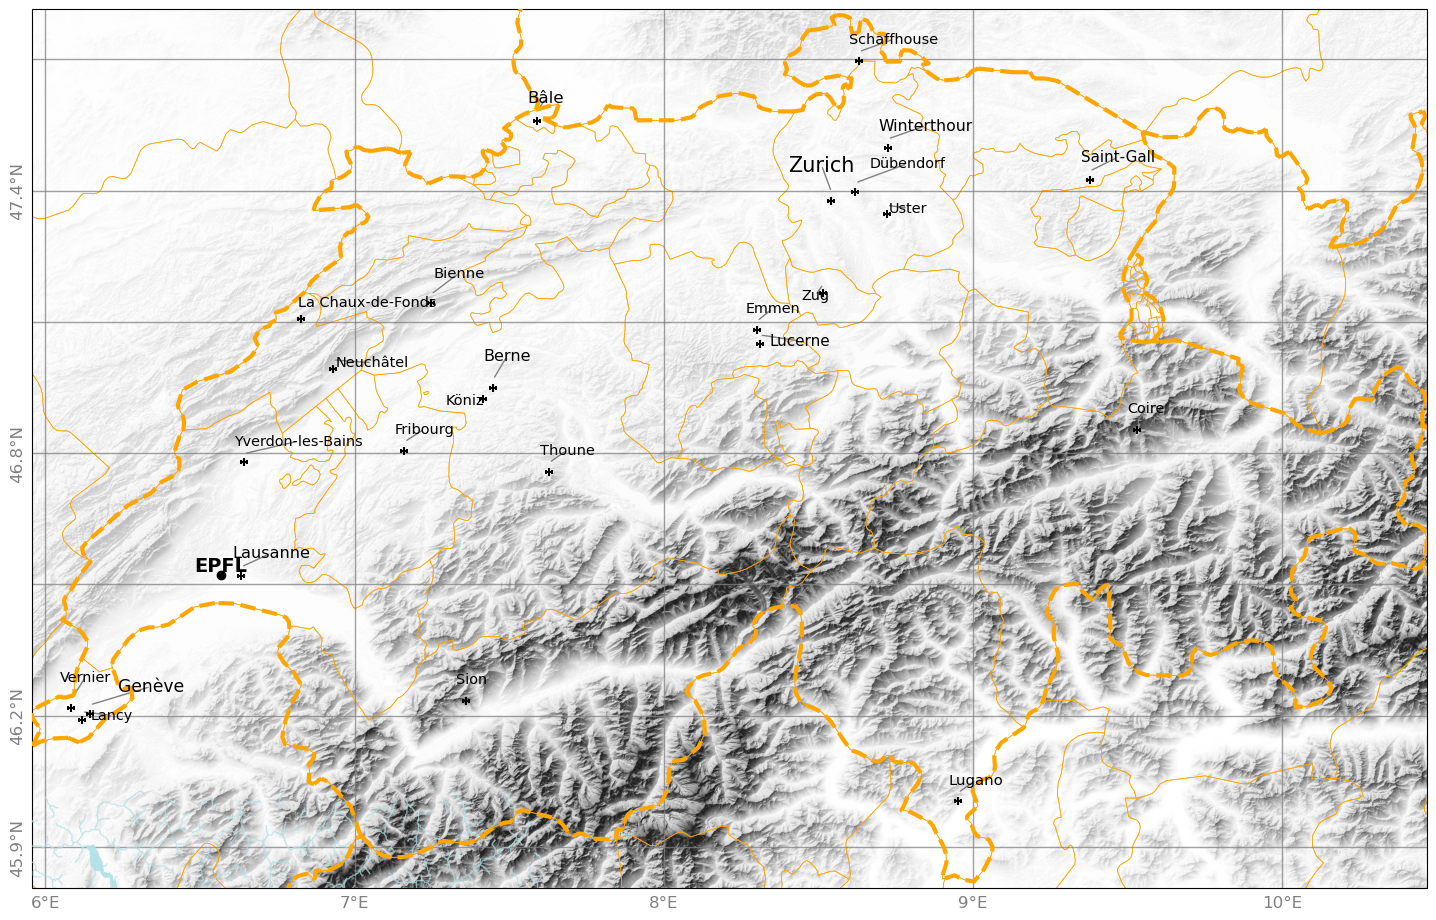

In [ ]:
# la fonction prend du temps lors de la première exécution
fig, _ = fond_topographique(6.56619476278459, 46.52030090079184, 'EPFL',seuil_pop=3e4)

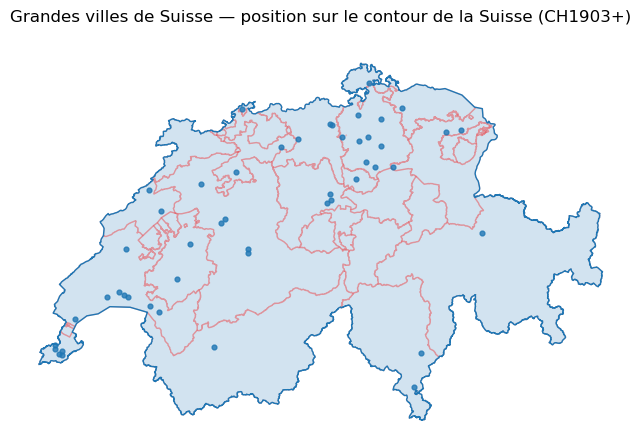

In [ ]:
# liste des villes de plus de 10 000 hab
df = liste_villes[liste_villes['population']>1e4].rename(columns={"longitude":'lon',"latitude":'lat'})

# carte avec limites administratives entre cantons
# fichier de données "swissBOUNDARIES3D" : https://opendata.swiss/en/dataset/swissboundaries3d/resource/e16e53fb-9768-45bf-8787-a7a20b92de14
carte_canton = Path(r"\Data\Cartographie\SwissBoundaries") / "SwissBOUNDARIES3D_1_5_TLM_KANTONSGEBIET.shp"
cantons = gpd.read_file(carte_canton)


# Frontière de la Suisse au format EPSG 2056 (CH 1903+)
url_ch1903 = "https://api3.geo.admin.ch/rest/services/api/MapServer/ch.swisstopo.swissboundaries3d-land-flaeche.fill/CH?geometryFormat=geojson&sr=2056"
response = requests.get(url_ch1903)
geojson_data = response.json()

feature = geojson_data['feature']
geometry = shape(feature['geometry'])
swiss = gpd.GeoDataFrame([feature['properties']], 
                        geometry=[geometry], 
                        crs="EPSG:2056")

# Villes
gdf = gpd.GeoDataFrame(
    df,   
    geometry=[Point(xy) for xy in zip(df.lon, df.lat)],
    crs="EPSG:4326"  # WGS84
)

# Projection des stations en CH1903+ 
gdf_ch1903 = gdf.to_crs("EPSG:2056")

# Tracé au format CH1903+
ax = swiss.boundary.plot(figsize=(8, 8), linewidth=1)
cantons.plot(ax=ax,alpha = 0.2,edgecolor='red')
gdf_ch1903.plot(ax=ax, markersize=12, alpha=0.8)
ax.set_title("Grandes villes de Suisse — position sur le contour de la Suisse (CH1903+)")
ax.set_axis_off()

## Collecter les données météo de Météo-Suisse

In [271]:
def télécharger_stations(collection_id,verbosité = False):
    """
    Récupère toutes les stations avec leurs URLs de données
    Entrée : 
        * nom de la collection. 
          Pour les stations manuelles, la collection est "ch.meteoschweiz.ogd-smn"
          Pour les stations automatiques, la collection est "ch.meteoschweiz.ogd-mine"
    Option :
        * verbosité : afficher les messages
    Sortie :
        * liste_station : liste de dictionnaires. Chaque dictionnaire (le fichier json de Météo-Suisse) contient les informations sur les stations.
    """
    base_url = f"https://data.geo.admin.ch/api/stac/v1/collections/{collection_id}/items"
    
    liste_stations = []
    next_url     = f"{base_url}?limit=100"
    
    while next_url:
        if verbosité: print(f"Récupération de {len(liste_stations)} stations...")
        resp = requests.get(next_url)
        resp.raise_for_status()
        data = resp.json()
        
        for feature in data['features']:
            coords = feature['geometry']['coordinates']
            props = feature['properties']
            
            # Extraire les URLs des assets
            data_urls = []
            if 'assets' in feature:
                for asset_key, asset in feature['assets'].items():
                    if asset.get('href'):  # Vérifier qu'il y a bien une URL
                        data_urls.append({
                            'asset_key': asset_key,
                            'url': asset['href'],
                            'type': asset.get('type', 'unknown'),
                            'title': asset.get('title', asset_key)
                        })
            
            liste_stations.append({
                'id': feature['id'],
                'name': props.get('title', feature['id']),
                'collection': collection_id.split('.')[-1],
                'lon': coords[0],
                'lat': coords[1],
                'date': props.get('datetime'),
                'data_urls': data_urls
            })
        
        # Chercher le lien "next"
        next_url = None
        for link in data.get('links', []):
            if link.get('rel') == 'next':
                next_url = link['href']
                break
    
    return liste_stations



def télécharger_précipitations(station_row, granularité = 'd',verbosité = False):
    """
    Récupère les données de précipitation pour une station Météo-Suisse 
        * ligne avec la liste des urls
        * granularité :  granularité des mesures (fréquence)  'd' (daily), 'h' (hourly), 't' (10min), 'm' (monthly), 'y' (yearly)
    Sortie :
        * dataframe avec un assemblage des fichiers cvs collectés
    """
    def télécharger_données(url,verbosité = verbosité):
        """
        Télécharge et lit un fichier CSV de Météo-Suisse
        """
        if verbosité: print(f"Téléchargement de {url}")
        resp = requests.get(url)
        resp.raise_for_status()
        
        # Lire le CSV (avec séparateur ;)
        df = pd.read_csv(io.StringIO(resp.text), delimiter=';')    
        return df

    all_data = []
    
    for url_info in station_row['data_urls']:
        if f'_{granularité}_' in url_info['asset_key']:
            try:
                data = télécharger_données(url_info['url'])
                data['source_file'] = url_info['asset_key']
                all_data.append(data)
                if verbosité: print(f"Le fichier {url_info['asset_key']} contient {len(data)} enregistrements.")
                
            except Exception as e:
                print(f" Argh... Erreur {url_info['asset_key']} : {e}")
    
    if all_data:
        combined = pd.concat(all_data, ignore_index=True)
        
        # Convertir la colonne de date
        if 'reference_timestamp' in combined.columns:
            combined['reference_timestamp'] = pd.to_datetime(combined['reference_timestamp'], 
                                                            format='%d.%m.%Y %H:%M')
            return combined.sort_values('reference_timestamp')
        
        return combined
    
    return pd.DataFrame()

def synthétiser_information_pluviométrique(stations_df, max_stations=None, verbosité = False):
    """
    Analyse rapide des données de précipitation pour plusieurs stations.
    Entrée :
        * dataframe des stations
        * nombre maximal de stations, par défaut il prend toutes les stations.  
        * verbosité : afficher les messages
    Sortie :
        * dataframe avec le nom du poste, l'abréviation, le type de mesures, les coordonnées géographiques, les dates de début
          et de fin, la durée de fonctionnement de la station (en jours), le cumul annuel moyen de précipitations en mm, la valeur
          maximale enregistrée en mm, et le nombre moyen de jours avec de la pluie par année
    """
    résultats = []

    if max_stations is None: max_stations = len(stations_df)

    # Initialisation
    pbar = tqdm(total=max_stations, desc="Processing", unit=" stations")
        
    for idx, station in stations_df.head(max_stations).iterrows():
        if verbosité: print(f"\nAnalyse {station['name']} ({idx+1}/{max_stations})")
        pbar.update(1)
        pbar.set_postfix(current=f"{idx}")
        
        try:
            daily_data = télécharger_précipitations(station, 'd', verbosité = verbosité)
            
            if not daily_data.empty and 'rre150d0' in daily_data.columns:
                valid_data = daily_data['rre150d0'].dropna()
                
                if len(valid_data) > 0:
                    date_range = daily_data[daily_data['rre150d0'].notna()]['reference_timestamp']
                    
                    résultats.append({
                        'nom': station['name'].split(' (')[0],
                        'abréviation': station['id'],
                        'type': station['type'],
                        'lon': station['lon'],
                        'lat': station['lat'],
                        'nombre_valeurs': len(valid_data),
                        'date_début': date_range.min(),
                        'date_fin': date_range.max(),
                        'durée': (date_range.max()-date_range.min()).days,
                        'cumul_annuel': int(valid_data.mean()*365.25),
                        'valeur_max': valid_data.max(),
                        'nb_jours_pluvieux': int(365.25*(valid_data > 0).sum() / (date_range.max()-date_range.min()).days)
                    })
        
        except Exception as e:
            print(f"Argh...  Erreur : {e}")
    pbar.close()
    return pd.DataFrame(résultats)

def télécharger_toutes_données_station(nom_station, df_stations, verbosité = False):
    """
    télécharger toutes les données d'une station dont le nom doit être dans df_stations
    Entrée :
        * nom_station : str, nom de la station parmi les 472 stations possibles
        * verbosité : afficher les messages lors de l'exécution
    Sortie :
        * DataFrame (data, valeur) avec toutes les données disponibles en fonction de la date
    """
    données_station = df_stations[df_stations['name'].str.contains(nom_station, case=False, na=False)]
    if not données_station.empty:
        if verbosité: print(f"La station {nom_station} a été trouvée :")
        station = données_station.iloc[0]
        if verbosité: print(f"Nom complet : {station['name']}")
        if verbosité: print(f"URLs disponibles dans le fichier STAC : {len(station['data_urls'])}")
        for url_info in station['data_urls']:
            if verbosité: print(f"  {url_info['asset_key']}: {url_info['url']}")
        toutes_données = télécharger_précipitations(df_stations.iloc[0], 'd', verbosité = verbosité)
        return toutes_données
    else:
        print(f"La station {nom_station} n'a pas été trouvée !")
        return None

def télécharger_variable_station(nom_station, variable: str, df_stations, verbosité = False, info_unité = False):
    """
    télécharger une variable donnée parmi une gamme de variables possibles (températures moyenne, minimale, maximale
        précitation, chute de neige journalière, épaisseur du manteau neigeux, humidité, pression).
    Entrée :
        * nom_station : str, nom de la station parmi les 432 stations possibles
        * variable : str, parmi les 8 variables possibles. Pour d'autres variables, il faut employer toutes les données 
          avec la fonction télécharger_toutes_données_station
        * verbosité : afficher les messages lors de l'exécution
        * info_unité : affiche l'unité de mesure
    Sortie :
        * DataFrame (data, valeur). Le nom des colonnes est abrégé.
    """
    dictionnaire_variables = {
        'température moyenne': 'tre200d0',
        'température maximale': 'tre200dx', 
        'température minimale': 'tre200dn',
        'précipitation': 'rre150d0',
        'neige': 'htoautd0',
        'manteau': 'dkl010d0',
        'humidité': 'ure200d0',
        'pression': 'prestad0'
        }
    dictionnaire_unité = {
        'température moyenne': '°C',
        'température maximale': '°C', 
        'température minimale': '°C',
        'précipitation': 'mm',
        'neige': 'cm',
        'manteau': 'cm',
        'humidité': '%',
        'pression': 'hPa'
        }
    dictionnaire_abreviation = {
        'température moyenne': 'TM',
        'température maximale': 'TX', 
        'température minimale': 'TN',
        'précipitation': 'P',
        'neige': 'N',
        'manteau': 'HN',
        'humidité': 'Hu',
        'pression': 'Pr'
        }
    if variable in dictionnaire_variables.keys():
        data = télécharger_toutes_données_station(nom_station, df_stations, verbosité=verbosité)
        if data is None:
            print(f"Argh... la station {nom_station} n'est pas trouvée !")
            return None
        else:
            variable_MS = dictionnaire_variables[variable]
            abreviation = dictionnaire_abreviation[variable]
            données = data[['reference_timestamp', variable_MS]].rename(columns={'reference_timestamp':'date',variable_MS:abreviation})
            if info_unité: print(f"Variable considérée : {variable}. Unité : {dictionnaire_unité[variable]}. Abréviation Météo-Suisse : {variable_MS}.")
            if info_unité: print(f"Nom de la colonne : {abreviation}. Abréviation Météo-Suisse : {variable_MS}.")
            return données
    else:
        print(f"Argh... la variable {variable} n'est pas reconnue ! Les variables possibles sont :")
        for x in dictionnaire_variables.keys():
            print(x)
        return None
        
def charger_liste_stations(type_station, verbosité=False):
    """ Cette fonction lit directement les informations depuis le site de Météo Suisse. Elle fournit des informations utiles telles que :
    - canton
    - altitude
    - coordonnées (WGS84 ou LV95)
    - propriétaire
    - url pour la localisation de la station
    Entrée :
        * type de station : str, 'automatique', 'manuelle', 'toutes'
    Sortie :
        * pandas dataframe 
    """
    if type_station == 'automatique':
        url = "https://data.geo.admin.ch/ch.meteoschweiz.ogd-smn/ogd-smn_meta_stations.csv"
    elif type_station == 'manuelle':
        url = "https://data.geo.admin.ch/ch.meteoschweiz.ogd-nime/ogd-nime_meta_stations.csv"
    elif type_station == 'toutes':
        # charge les deux tpyes
        df_auto = charger_liste_stations('automatique', verbosité=False)
        df_manuelle = charger_liste_stations('manuelle', verbosité=False)
        
        # ajouter type
        #df_auto['type_station'] = 'automatique'
        #df_manuelle['type_station'] = 'manuelle'
        
        # assembler les data frames
        df = pd.concat([df_auto, df_manuelle], ignore_index=True)
        
        if verbosité:
            print(f"Nombre total de stations: {len(df)}")
            print(f"Dont {len(df_auto)} stations automatiques")
            print(f"Et {len(df_manuelle)} stations manuelles")
        
        return df
    else:
        raise ValueError("type_station doit être 'automatique', 'manuelle' ou 'toutes'")
    
    # lecture du fichier Météo Suisse
    df = pd.read_csv(url, encoding='latin-1', on_bad_lines='skip', sep=";")
    response = requests.get(url)
    total_lines = len(response.text.split('\n'))

    if verbosité: 
        print(f"Nombre de lignes dans le fichier originel : {total_lines}")
        print(f"Nombre de lignes lues : {len(df)}")
        print(f"Nombre de lignes non lues {total_lines - len(df)}")
        print(f"il y a {len(df.columns.values)} colonnes :")
        for x in df.columns.values:
            print(f"* {x}")
    
    liste_variables_MS = ['station_abbr','station_name','station_height_masl','station_canton','station_type_fr','station_dataowner','station_data_since','station_coordinates_wgs84_lat',
                'station_coordinates_wgs84_lon', 'station_coordinates_lv95_east','station_coordinates_lv95_north','station_url_fr']
    liste_variables_fr = ['abréviation','nom','altitude','canton','mesures','propriétaire','date_début','lat',
                'lon', 'x','y','url']
    renommer_colonnes = {x:y for x, y in zip(liste_variables_MS ,liste_variables_fr)}
    df = df[liste_variables_MS].rename(columns=renommer_colonnes)
    df['mesures'] = df.apply(lambda x: x['mesures'].split(" ")[-1], axis=1)
    
    return df

# Extraction des données

## Liste des stations

In [276]:
# Récupérer les stations avec les liens url des données brutes
print("Récupération des stations automatiques...")
stations_automatiques = télécharger_stations("ch.meteoschweiz.ogd-smn")
print("Récupération des stations manuelles...")
stations_manuelles = télécharger_stations("ch.meteoschweiz.ogd-nime")
for station in stations_automatiques:
    station['type'] = 'automatique'

for station in stations_manuelles:
    station['type'] = 'manuelle'


# liste totale
liste_stations = stations_automatiques + stations_manuelles
df_stations = pd.DataFrame(liste_stations)

print(f"\nIl y a {len(df_stations)} stations dans la base Météo-Suisse :")
print(f"* stations automatiques : {len(stations_automatiques)} \n* stations manuelles : {len(stations_manuelles)}")
liste_propriétés_stations = charger_liste_stations('toutes',verbosité = True)

Récupération des stations automatiques...
Récupération des stations manuelles...

Il y a 432 stations dans la base Météo-Suisse :
* stations automatiques : 158 
* stations manuelles : 274
Nombre total de stations: 432
Dont 158 stations automatiques
Et 274 stations manuelles


## Exportation de la liste des postes

In [277]:
res = synthétiser_information_pluviométrique(df_stations, max_stations=5) # supprimer l'argument  max_stations pour tout télécharger
res.to_csv("liste_stations.csv", sep='\t', encoding='utf-8',index = False)

Processing: 100%|██████████| 5/5 [00:04<00:00,  1.20 stations/s, current=4]  


In [220]:
res

,nom,abréviation,type,lon,lat,nombre_valeurs,date_début,date_fin,durée,cumul_annuel,valeur_max,nb_jours_pluvieux
0,Adelboden,abo,automatique,7.560703,46.491703,45451,1901-01-01,2025-09-08,45541,1298,95.3,172
1,Aigle,aig,automatique,6.924472,46.326647,16322,1981-01-01,2025-09-08,16321,999,68.9,154
2,Altdorf,alt,automatique,8.621894,46.887069,58942,1864-01-01,2025-09-08,59055,1199,147.2,170
3,Andeer,and,automatique,9.431981,46.610139,45030,1901-01-01,2025-09-08,45541,970,130.2,126


## Carte des stations météo sur fond fixe

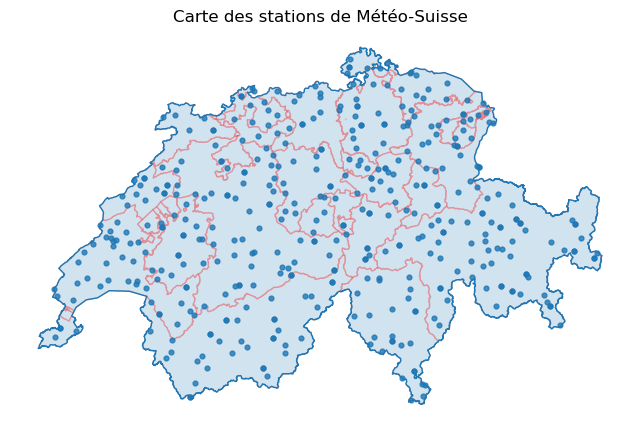

In [195]:
# carte avec limites administratives entre cantons
# fichier de données "swissBOUNDARIES3D" : https://opendata.swiss/en/dataset/swissboundaries3d/resource/e16e53fb-9768-45bf-8787-a7a20b92de14
carte_canton = Path(r"\Data\Cartographie\SwissBoundaries") / "SwissBOUNDARIES3D_1_5_TLM_KANTONSGEBIET.shp"
cantons = gpd.read_file(carte_canton)


# Frontière de la Suisse au format EPSG 2056 (CH 1903+)
url_ch1903 = "https://api3.geo.admin.ch/rest/services/api/MapServer/ch.swisstopo.swissboundaries3d-land-flaeche.fill/CH?geometryFormat=geojson&sr=2056"
response = requests.get(url_ch1903)
geojson_data = response.json()

feature = geojson_data['feature']
geometry = shape(feature['geometry'])
swiss = gpd.GeoDataFrame([feature['properties']], 
                        geometry=[geometry], 
                        crs="EPSG:2056")

# Villes
gdf = gpd.GeoDataFrame(
    df_stations,   
    geometry=[Point(xy) for xy in zip(df_stations.lon, df_stations.lat)],
    crs="EPSG:4326"  # WGS84
)

# Projection des stations en CH1903+ 
gdf_ch1903 = gdf.to_crs("EPSG:2056")

# Tracé au format CH1903+
ax = swiss.boundary.plot(figsize=(8, 8), linewidth=1)
cantons.plot(ax=ax,alpha = 0.2,edgecolor='red')
gdf_ch1903.plot(ax=ax, markersize=12, alpha=0.8)
ax.set_title("Carte des stations de Météo-Suisse")
ax.set_axis_off()

## Carte des stations météo avec indication des noms

In [281]:
selection = liste_propriétés_stations
# trace une carte plotly des stations selon le type
fig = px.scatter_map(selection, 'lat', lon= 'lon', 
                        hover_name= "nom", hover_data= ["lat", "lon", "mesures","altitude","canton","date_début"], 
                        height= 800, width= 900, color = 'mesures'
                        )

 
title=  '   postes Météo-Suisse en activité en ' +  str(année_en_cours)
fig.update_layout(title_text= title, title_x=0.5  , hoverlabel= dict(bgcolor= 'rgb(255,255,255)'))
fig.update_traces(
        marker=go.scattermap.Marker(
            size=10,
            opacity=1.0
        )
    )

#===================== Ajoute une couche des départements français à partir d'un fichier GeoJSON
fig.update_layout(map_layers=[
    {
        "sourcetype": "geojson",
        # "source": "https://france-geojson.gregoiredavid.fr/repo/departements.geojson",
        "source": "https://www.data.gouv.fr/fr/datasets/r/90b9341a-e1f7-4d75-a73c-bbc010c7feeb", 
        "type": "line",
        "color": "rgba(0, 0, 0, 0.9)",
        "line": {"width": 1}
    }
    ])
fig.update_layout(map_style= "open-street-map", map_zoom=6.5, map_center = {"lat": central_latitude, "lon": central_longitude})

## Extraction des données

In [221]:
# Chercher une station


data = télécharger_toutes_données_station('Pully',df_stations)  
data

,station_abbr,reference_timestamp,tre200d0,tre200dx,tre200dn,tre005d0,tre005dx,tre005dn,ure200d0,pva200d0,...,ods000d0,sre000d0,sremaxdv,erefaod0,xcd000d0,dkl010d0,xno000d0,xno012d0,rreetsd0,source_file
0,ABO,1901-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ogd-smn_abo_d_historical.csv
1,ABO,1901-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ogd-smn_abo_d_historical.csv
2,ABO,1901-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ogd-smn_abo_d_historical.csv
3,ABO,1901-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ogd-smn_abo_d_historical.csv
4,ABO,1901-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ogd-smn_abo_d_historical.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45446,ABO,2025-09-04,13.1,18.3,9.3,12.4,21.6,7.8,83.5,12.5,...,80.0,46.0,8.0,1.7,0.0,63.0,0.0,0.0,17.2,ogd-smn_abo_d_recent.csv
45447,ABO,2025-09-05,9.2,12.8,5.9,9.2,17.3,2.7,90.5,10.5,...,86.0,179.0,30.0,1.7,0.0,63.0,10.8,2.8,5.7,ogd-smn_abo_d_recent.csv
45448,ABO,2025-09-06,11.5,17.9,4.6,10.8,22.5,1.6,65.1,8.5,...,48.0,592.0,100.0,2.9,0.0,76.0,8.5,0.5,-4.6,ogd-smn_abo_d_recent.csv
45449,ABO,2025-09-07,15.9,22.4,9.9,14.1,26.1,4.3,47.2,8.3,...,39.0,591.0,100.0,3.5,0.0,45.0,0.0,0.0,-6.6,ogd-smn_abo_d_recent.csv


In [201]:
station = "Sion"
données_pluie = télécharger_variable_station(station,'précipitation',df_stations,info_unité=True)
données_température = télécharger_variable_station(station, 'température moyenne',df_stations,info_unité=True) 
 

Variable considérée : précipitation. Unité : mm. Abréviation Météo-Suisse : rre150d0.
Nom de la colonne : P. Abréviation Météo-Suisse : rre150d0.
Variable considérée : température moyenne. Unité : °C. Abréviation Météo-Suisse : tre200d0.
Nom de la colonne : TM. Abréviation Météo-Suisse : tre200d0.


* Le maximum a été atteint le 16/04/2025 avec un cumul journalier de 95.3 mm.


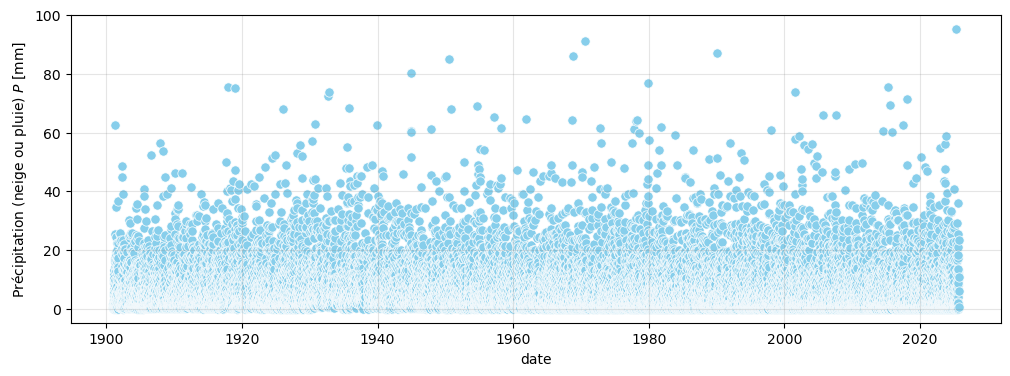

In [206]:
# distribution temporelle des distributions
fig, ax = plt.subplots(figsize=(12,4))
ax.scatter(données_pluie[données_pluie["P"]>0]['date'], données_pluie[données_pluie["P"]>0]["P"] ,  marker = "o",edgecolors='white', linewidths=0.5,s=45, color='skyblue', alpha = 1)
ax.set_ylabel(r'Précipitation (neige ou pluie) $P$ [mm]')
ax.set_xlabel(r'date')
max_pluie = np.nanmax(données_pluie["P"])
date_max = données_pluie[données_pluie["P"]==max_pluie]['date']
if  len(données_pluie[données_pluie["P"]==max_pluie].index)>1:
      date_max =  données_pluie[données_pluie["P"]==max_pluie]['date'].first
      date_max = str((données_pluie[données_pluie["P"]==max_pluie]['date'].values )[0])[:-10]
      
      info = "* Le maximum a été reporté deux fois."

else:
      date_max = données_pluie[données_pluie["P"]==max_pluie]['date'].to_string(index = False)
if len(date_max)==10:
      date_max = datetime.datetime.strptime(date_max ,"%Y-%m-%d").strftime("%d/%m/%Y")
else:
      date_max = datetime.datetime.strptime(date_max ,"%Y-%m-%dT%S:%M:%H").strftime("%d/%m/%Y")
  
print("* Le maximum a été atteint le "+date_max+" avec un cumul journalier de {:.1f} mm.".format(max_pluie))
 
plt.grid(True, color = 'gray', alpha=0.2)

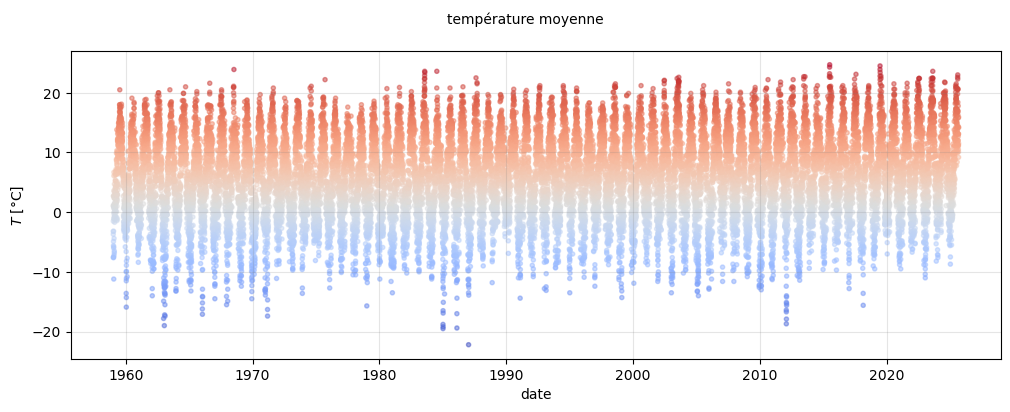

In [205]:

# distribution temporelle des température
fig, ax = plt.subplots(figsize=(12,4))

ax.set_ylabel(r'$T$ [°C]')
ax.set_xlabel(r'date')
 
ax.scatter(données_température['date'], données_température["TM"] ,   c=données_température["TM"],marker = "." , cmap = 'coolwarm', 
           alpha = 0.5,label = "température moyenne")
fig.legend(loc='outside upper center',frameon = False)
plt.grid(True, color = 'gray', alpha=0.2)